In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
nasdaq = pd.read_csv("ナスダック100 過去データ.csv")#.loc[:4000]

In [3]:
nasdaq

,日付け,終値,始値,高値,安値,出来高,前日比%
0,2019年11月14日,"8,257.83","8,238.85","8,264.94","8,212.59",132.49M,-0.02%
1,2019年11月13日,"8,259.81","8,235.68","8,274.61","8,233.38",136.69M,-0.05%
2,2019年11月12日,"8,263.79","8,249.62","8,293.18","8,238.33",129.36M,0.27%
3,2019年11月11日,"8,241.91","8,212.37","8,245.89","8,202.36",112.63M,-0.17%
4,2019年11月08日,"8,255.89","8,208.37","8,256.29","8,186.31",135.07M,0.44%
...,...,...,...,...,...,...,...
4995,2000年01月07日,"3,529.60","3,337.26","3,529.75","3,314.75",-,5.65%
4996,2000年01月06日,"3,340.81","3,488.31","3,513.55","3,334.02",-,-4.75%
4997,2000年01月05日,"3,507.31","3,543.13","3,576.17","3,371.75",-,-1.10%
4998,2000年01月04日,"3,546.20","3,766.57","3,766.57","3,542.73",-,-6.45%


In [59]:
l_rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values*3 + 1
rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values + 1
l_rates = np.insert(l_rates, 0, 1)
rates = np.insert(rates, 0, 1)

In [60]:
def laplace(x, m, v):
    b = (v/2)**0.5
    return np.exp(-abs(x-m)/b)/2/b

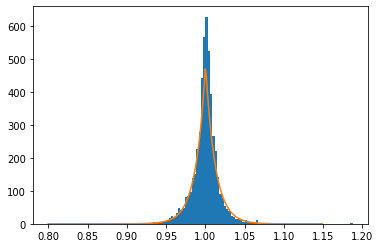

In [61]:
data = rates[1:]
_ = plt.hist(data, bins=100, )
X = np.arange(0.8, 1.15, 0.001)
plt.plot(X, 12*laplace(X, np.mean(data), np.var(data)))

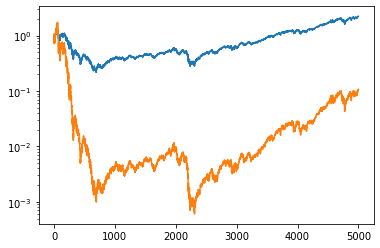

In [62]:
plt.plot(np.cumprod(rates))
plt.plot(np.cumprod(l_rates))
plt.yscale('log')

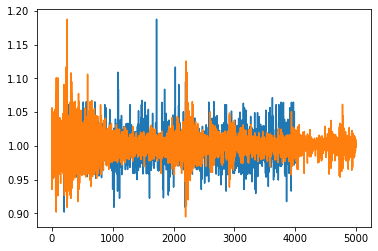

In [8]:
r = np.random.choice(rates, 4000, replace=True)
plt.plot(r)
plt.plot(rates)

In [9]:
def exe(leverage=3, day_num=100, sp=1):
    arr_list = [[0.8, 1.1, 1.1, 1.04]]
    N = day_num//10
    for _ in range(N):
        r = ((sp**(1/N))**(1/10))+np.random.randn(9)*0.005
        arr_list.append(r)
        arr_list.append([sp**(1/N)/np.prod(r)])
    r = np.concatenate(arr_list)
    np.random.shuffle(r)
    return np.prod(leverage*(r-1)+1)

In [10]:
exe2_rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values
def exe2(leverage=3, day_num=100, ):
    r = np.random.choice(exe2_rates, day_num, replace=True)*leverage + 1
    return np.prod(r)

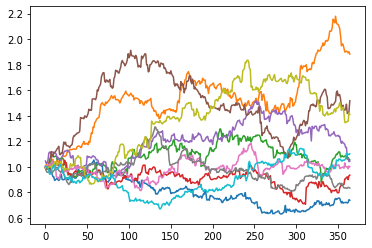

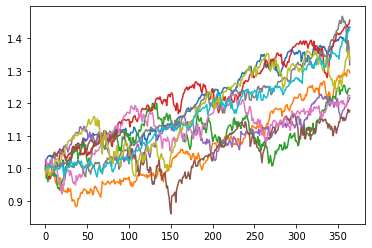

In [11]:
rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values + 1
for _  in range(10):
    r = np.random.choice(rates, 365, replace=True)
    plt.plot(r.cumprod())
plt.show()
    
for _  in range(10):
    start = np.random.choice(np.arange(len(rates)-365), 1)[0]
    plt.plot(rates[start:start+365].cumprod())
plt.show()

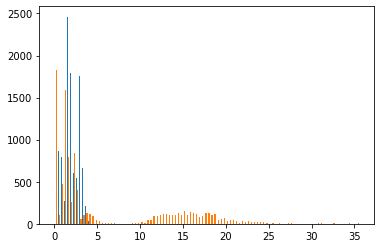

In [12]:
D = 1800
rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values
res1 = []
res2 = []
res3 = []
np.random.seed(100)
for _  in range(10000):
    r = np.random.choice(rates, D, replace=True) + 1
    res1.append(np.prod(r))
    
np.random.seed(100)
for _  in range(10000):
    start = np.random.choice(np.arange(len(rates)-D), 1)[0] 
    res2.append(np.prod(rates[start:start+D]+1))
    
np.random.seed(100)
for _  in range(10000):
    start = np.random.choice(np.arange(len(rates)-D), 1)[0] 
    res3.append(np.prod(rates[start:start+D]*3+1))
    
__ = plt.hist([res2,res3], bins=100)

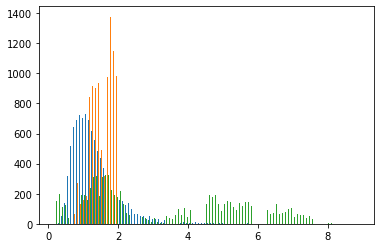

In [13]:
D = 365*5
rates = nasdaq["前日比%"].apply(lambda x: float(x[:-1])/100)[::-1].values

def doll_cost(rates):
    cp = np.cumprod(rates)
    r = cp[-1]/cp
    return r.mean()
dres1 = []
dres2 = []
dres3 = []
np.random.seed(100)
for _  in range(10000):
    r = np.random.choice(rates, D, replace=True) + 1
    dres1.append(doll_cost(r))
    
np.random.seed(100)
for _  in range(10000):
    start = np.random.choice(np.arange(len(rates)-D), 1)[0] 
    dres2.append(doll_cost(rates[start:start+D]+1))
    
np.random.seed(100)
for _  in range(10000):
    start = np.random.choice(np.arange(len(rates)-D), 1)[0] 
    dres3.append(doll_cost(rates[start:start+D]*3+1))
    
__ = plt.hist([dres1, dres2, dres3], bins=100)

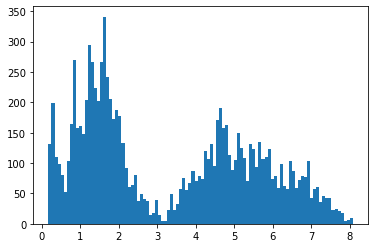

In [14]:
_ = plt.hist(dres3, bins=100)

In [31]:
np.mean(dres3)

3.328315426972916

In [64]:
np.sum(np.array(dres3)5)/len(dres3)

0.2814

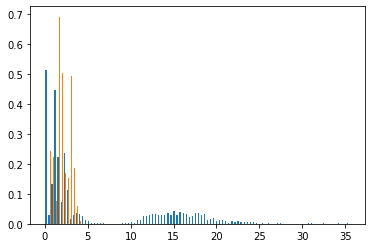

In [17]:
_ = plt.hist([res3, res2], bins=100,density=True)

In [18]:
np.mean(res3),  np.mean(res2)

(6.070720024488851, 2.0457764354387824)

In [19]:
np.sum(np.array(res3)>=1)/len(res3), np.sum(np.array(res2)>=1)/len(res3)

(0.7804, 0.8478)

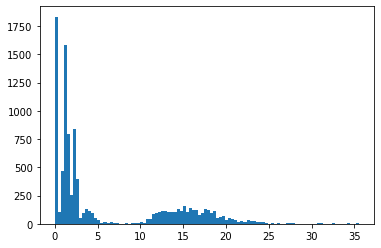

In [25]:
_ = plt.hist(res3, bins=100)
#_ = plt.hist(res3, bins=100, range=(0, 4))

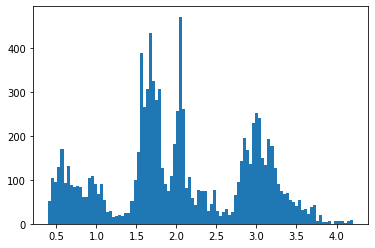

In [21]:
_ = plt.hist(res2, bins=100)

In [22]:
np.sum(np.array(res3)>2)/len(res3), np.sum(np.array(res2)>2)/len(res3)

(0.5109, 0.4857)

In [23]:
np.sum(np.array(res3)<0.1)/len(res3), np.sum(np.array(res2)<0.1)/len(res3)

(0.1118, 0.0)

1.0割に下がる確率 0.0002
1.7637046303483264 1.559790828029671


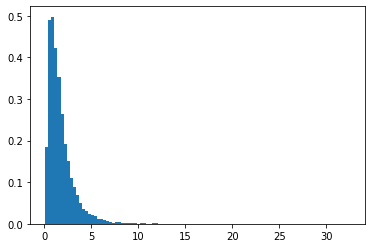

1.0割に下がる確率 0.0602
3.1447838265351007 10.565242284190129


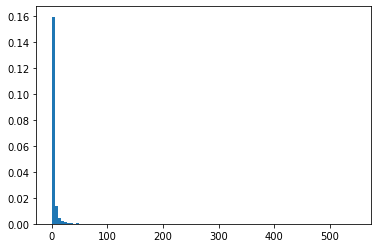

1.0割に下がる確率 0.2549
6.003962684625418 68.51402449389211


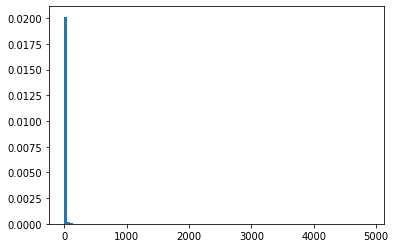

1.0割に下がる確率 0.4871
11.959900904152601 298.76580266242166


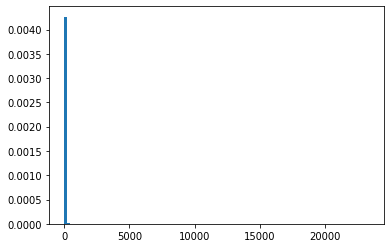

In [24]:
for l in [1, 2, 3, 4]:
    res = []
    np.random.seed(100)
    for _ in range(10000):
        res.append(exe2(leverage=l, day_num=3650//2,))
    _ = plt.hist(res, bins=100, density=True)
    ref = 0.1
    print(f"{ref*10}割に下がる確率", np.sum(np.array(res)<ref)/len(res))
    print(np.mean(res), np.std(res))
    plt.show()